<a href="https://colab.research.google.com/github/ccraig3/ece697-mri-denoising/blob/main/Rician_Noise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Install Packages
!pip install python-gdcm
!pip install pydicom
!pip install antspyx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 MB 6.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 7.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 319.4 MB 32 kB/s 
     |████████████████████████████████| 64 kB 2.5 MB/s 
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11447 sha256=060dda0572d279ea701e6066213a64e93fccfb9f3bfe171a95e4216349b97c02
  Stored in directory: /root/.cache/pip/wheels/f9/8d/8d/f6af3f7f9eea3553bc2fe6d53e4b287dad18b06a861ac56ddf
Successfully built retrying


In [2]:
#@title Imports
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from PIL import Image as im, ImageOps
import pydicom
import ants

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
def normalize(image):
  new_image = image - np.min(image)
  return new_image / np.max(new_image)

In [5]:
def clip_img(image):
  image = np.where(image > 1, 1, image)
  return np.where(image < 0, 0, image)

In [6]:
def add_rician_noise(image, intensity=1):
  n1 = np.random.normal(0, 1, image.shape)
  n2 = np.random.normal(0, 1, image.shape)
  return clip_img(np.abs(image + intensity*normalize(n1) + intensity*normalize(n2)*1j))

In [7]:
def show(image):
  display(im.fromarray(np.uint8(image * 255)))

In [8]:
def save_as_img(np_array, filename):
  img = im.fromarray(np.uint8(cm.gray(normalize(np_array))*255))
  img.save(filename)

In [9]:
# Knee MRI
path = r'/content/drive/MyDrive/ECE697/data/share/knee_mri_dicom_batch2/knee_mri_clinical_seq_batch2/1FB_1219593033____1FB,_3165601921/study_d412fd72/MR11_d52d9b84/00022_a608002f68ed2aea.dcm'
ds = pydicom.dcmread(path)
ds.decompress('gdcm')
img = ds.pixel_array
img = normalize(img)

In [59]:
# Circular Saw
img = im.open('/content/drive/MyDrive/ECE697/data/tools/tools020.png')
mask = np.asarray(img)[:,:,3]
img = ImageOps.grayscale(img)
img = np.asarray(img)
img = np.where(mask > 0, img, 0 )
img = normalize(img)

In [ ]:
# Random Brain MRI
img = Image.open('/content/brain_mri_clean.jpeg')
img = np.asarray(img)

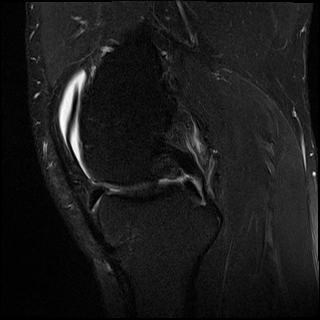

In [10]:
show(img)

In [ ]:
save_as_img(img, 'mri_clean_input.png')

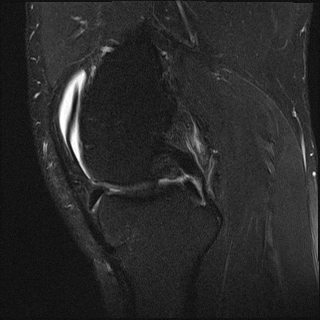

In [11]:
show(add_rician_noise(img, 0.1))

In [ ]:
save_as_img(add_rician_noise(img, 0.12), 'brain_slightly_noisy.png')

In [12]:
img.shape

(320, 320)

In [13]:
SIZE = img.shape[0]
x = np.linspace(-1, 1, num=SIZE)

In [41]:
y_vert = (1 / (0.8 + np.exp(-3*x))) + 0.2
#y_vert = (y_vert / np.max(np.absolute(y_vert))) + 1


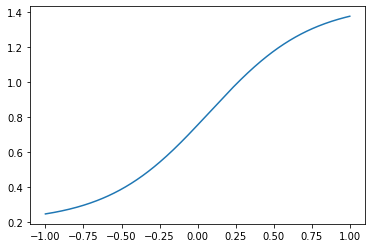

In [42]:
plt.plot(x, y_vert)

In [43]:
y_horiz = -(x**4)
y_horiz = (y_horiz / np.max(np.absolute(y_horiz))) + 1

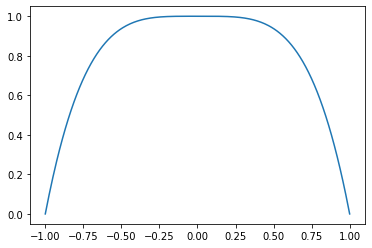

In [44]:
plt.plot(x, y_horiz)

In [45]:
np.reshape(y_vert, (-1, 1)).shape

(320, 1)

In [62]:
vert_mask = (normalize(np.tile(np.reshape(y_vert, (-1, 1)), (1, SIZE))) * 0.95) + 0.05

In [63]:
horiz_mask = normalize(np.tile(np.reshape(y_horiz, (1, -1)), (SIZE, 1)))

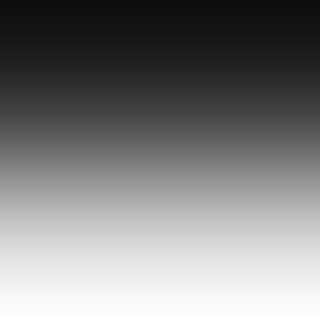

In [64]:
show(vert_mask)

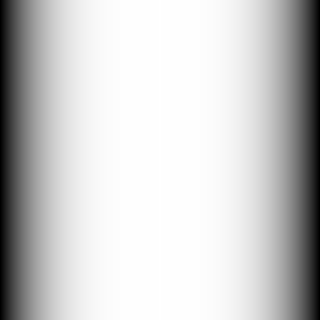

In [65]:
show(horiz_mask)

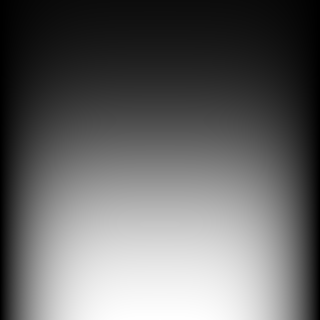

In [66]:
#mask = (vert_mask + horiz_mask) / 2
mask = 4*vert_mask * horiz_mask
#mask = mask / np.max(mask)
mask = normalize(mask)
show(mask)

In [67]:
np.max(mask)

1.0

In [68]:
np.min(mask)

0.0

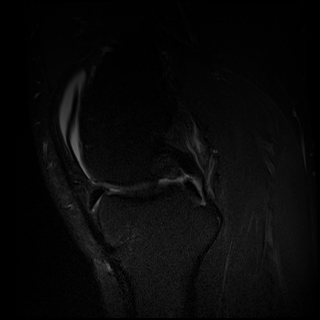

In [69]:
show(np.multiply(img, mask))

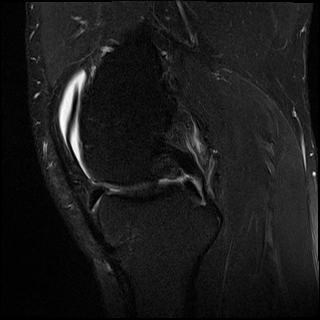

In [70]:
show(img)

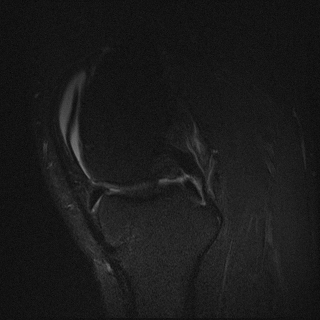

In [72]:
sim_singlecoil = add_rician_noise(np.multiply(img, mask), 0.1)
show(sim_singlecoil)

In [ ]:
save_as_img(sim_singlecoil, 'knee_noisy_output.png')

In [ ]:
aimg = ants.from_numpy(circ_singlecoil)

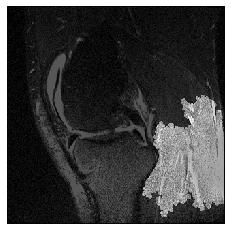

In [ ]:
corrected = ants.abp_n4(aimg, intensity_truncation=(0.025, 0.95, 256), usen3=False)
cimg = corrected.numpy()
show(cimg)